In [1]:
# Imports
import numpy as np
import pandas as pd 
import os
#from utilities import *
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

%matplotlib inline

In [ ]:
#pip install utilities-package

In [2]:
def read_data(data_path, split = "train"):
	""" Read data """

	# Fixed params
	n_class = 6
	n_steps = 128

	# Paths
	path_ = os.path.join(data_path, split)
	path_signals = os.path.join(path_, "Inertial Signals")

	# Read labels and one-hot encode
	label_path = os.path.join(path_, "y_" + split + ".txt")
	labels = pd.read_csv(label_path, header = None)

	# Read time-series data
	channel_files = os.listdir(path_signals)
	channel_files.sort()
	n_channels = len(channel_files)
	posix = len(split) + 5

	# Initiate array
	list_of_channels = []
	X = np.zeros((len(labels), n_steps, n_channels))
	i_ch = 0
	for fil_ch in channel_files:
		channel_name = fil_ch[:-posix]
		dat_ = pd.read_csv(os.path.join(path_signals,fil_ch), delim_whitespace = True, header = None)
		X[:,:,i_ch] = dat_.values

		# Record names
		list_of_channels.append(channel_name)

		# iterate
		i_ch += 1

	# Return 
	return X, labels[0].values, list_of_channels

def standardize(train, test):
	""" Standardize data """

	# Standardize train and test
	X_train = (train - np.mean(train, axis=0)[None,:,:]) / np.std(train, axis=0)[None,:,:]
	X_test = (test - np.mean(test, axis=0)[None,:,:]) / np.std(test, axis=0)[None,:,:]

	return X_train, X_test

def one_hot(labels, n_class = 6):
	""" One-hot encoding """
	expansion = np.eye(n_class)
	y = expansion[:, labels-1].T
	assert y.shape[1] == n_class, "Wrong number of labels!"

	return y

def get_batches(X, y, batch_size = 100):
	""" Return a generator for batches """
	n_batches = len(X) // batch_size
	X, y = X[:n_batches*batch_size], y[:n_batches*batch_size]

	# Loop over batches and yield
	for b in range(0, len(X), batch_size):
		yield X[b:b+batch_size], y[b:b+batch_size]
	

In [5]:
# 각자의 데이터 경로로 수정 
X_train, labels_train, list_ch_train = read_data(data_path="/content/drive/MyDrive/UCI HAR Dataset/", split="train") # train
X_test, labels_test, list_ch_test = read_data(data_path="/content/drive/MyDrive/UCI HAR Dataset/", split="test") # test

assert list_ch_train == list_ch_test, "Mistmatch in channels!"

In [6]:
# Normalize?
X_train, X_test = standardize(X_train, X_test)

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [16]:
X_tr, X_vld, lab_tr, lab_vld = train_test_split(X_train, labels_train, 
                                                stratify = labels_train, random_state = 123)

In [17]:
y_tr = one_hot(lab_tr)
y_vld = one_hot(lab_vld)
y_test = one_hot(labels_test)

In [18]:
# Imports

import tensorflow.compat.v1 as tf 
tf.disable_v2_behavior()



In [19]:
batch_size = 600       # Batch size
seq_len = 128          # Number of steps
learning_rate = 0.0001
epochs =100  #1000

n_classes = 6
n_channels = 9

As in many CNN architectures, the deeper the layers get, the higher the number of filters become.

In [20]:
class  New_CNN:

    def __init__(self, name):
        self.name = name

    def __call__(self, X, reuse=False):

        with tf.variable_scope(self.name) as scope:

            if reuse:
                scope.reuse_variables()

            with tf.variable_scope('layer0'):
                X_img = X

            # Convolutional Layer #1 
            with tf.variable_scope('layer1'):
                # (batch, 128, 9) --> (batch, 128, 18)
                conv1 = tf.layers.conv1d(inputs=X_img, filters=18, kernel_size=2,
                                         padding='same', activation = tf.nn.relu, use_bias=False)

            # Convolutional Layer #2 
            with tf.variable_scope('layer2'):
                # (batch, 64, 18) --> (batch, 128, 36)
                conv2 = tf.layers.conv1d(inputs=conv1, filters=36, kernel_size=2,  
                                         padding='same', activation = tf.nn.relu, use_bias=False)

            # Convolutional Layer #3 
            with tf.variable_scope('layer3'):
                # (batch, 32, 36) --> (batch, 128, 72)
                conv3 = tf.layers.conv1d(inputs=conv2, filters=72, kernel_size=2, 
                                         padding='same', activation = tf.nn.relu, use_bias=False)


            # Dense Layer with Relu
            with tf.variable_scope('layer4'):
                # (batch, 16, 72) --> (batch, 128, 144)
                conv4 = tf.layers.conv1d(inputs=conv3, filters=144, kernel_size=2, 
                                         padding='same', activation = tf.nn.relu, use_bias=False)

            # Logits (no activation) Layer: L5 Final FC 625 inputs -> 10 outputs
            with tf.variable_scope('layer5'):
                # Flatten and add dropout
                flat = tf.reshape(conv4, (-1, 128*144))
    
                # Predictions
                logits = tf.layers.dense(flat, n_classes, use_bias=False)
                prediction = tf.nn.softmax(logits)



        return [X_img, conv1, conv2, conv3,conv4, flat, prediction], logits
    
    @property
    def vars(self):
        return tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=self.name)
    
    
    

In [21]:
graph = tf.Graph()

# Construct placeholders
with graph.as_default():
    
    new_CNN = New_CNN('CNN')
    
    inputs_ = tf.placeholder(tf.float32, [None, seq_len, n_channels], name = 'inputs')
    labels_ = tf.placeholder(tf.float32, [None, n_classes], name = 'labels')
    keep_prob_ = tf.placeholder(tf.float32, name = 'keep')
    learning_rate_ = tf.placeholder(tf.float32, name = 'learning_rate')

In [22]:
with graph.as_default():
    
    activations, logits = new_CNN(inputs_)
    
    tf.add_to_collection('DTD', inputs_)
    
    for activation in activations:
        tf.add_to_collection('DTD', activation)
    
    # Cost function and optimizer
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels_))
    optimizer = tf.train.AdamOptimizer(learning_rate_).minimize(cost)
    
    # Accuracy
    correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(labels_, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: `tf.layers.conv1d` is deprecated and will be removed in a future version. Please Use `tf.keras.layers.Conv1D` instead.
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/convolutional.py:288: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: `tf.layers.conv1d` is deprecated and will be removed in a future version. Please Use `tf.keras.layers.Conv1D` instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: UserWarning: `tf.layers.conv1d` is deprecated and will be removed in a future version. Please Use `tf.keras.layers.Conv1D` instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: UserWarning: `tf.layers.conv1d` is deprecated and will be removed in a future version. Please Use `tf.ker

In [25]:
if (os.path.exists('checkpoints-cnn') == False):
    !mkdir checkpoints-cnn

In [27]:
validation_acc = []
validation_loss = []

train_acc = []
train_loss = []

with graph.as_default():
    saver = tf.train.Saver()

config = tf.ConfigProto()
config.gpu_options.allow_growth = True    
    
with tf.Session(config=config,graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    iteration = 1
   
    # Loop over epochs
    for e in range(epochs):
        
        # Loop over batches
        for x,y in get_batches(X_tr, y_tr, batch_size):
            
            # Feed dictionary
            feed = {inputs_ : x, labels_ : y, keep_prob_ : 0.5, learning_rate_ : learning_rate}
            
            # Loss
            loss, _ , acc = sess.run([cost, optimizer, accuracy], feed_dict = feed)
            train_acc.append(acc)
            train_loss.append(loss)
            
            # Print at each 5 iters
            if (iteration % 100 == 0):
                print("Epoch: {}/{}".format(e, epochs),
                      "Iteration: {:d}".format(iteration),
                      "Train loss: {:6f}".format(loss),
                      "Train acc: {:.6f}".format(acc))
            
            # Compute validation loss at every 10 iterations
            if (iteration%100 == 0):                
                val_acc_ = []
                val_loss_ = []
                
                for x_v, y_v in get_batches(X_vld, y_vld, batch_size):
                    # Feed
                    feed = {inputs_ : x_v, labels_ : y_v, keep_prob_ : 1.0}  
                    
                    # Loss
                    loss_v, acc_v = sess.run([cost, accuracy], feed_dict = feed)                    
                    val_acc_.append(acc_v)
                    val_loss_.append(loss_v)
                
                # Print info
                print("Epoch: {}/{}".format(e, epochs),
                      "Iteration: {:d}".format(iteration),
                      "Validation loss: {:6f}".format(np.mean(val_loss_)),
                      "Validation acc: {:.6f}".format(np.mean(val_acc_)))
                
                # Store
                validation_acc.append(np.mean(val_acc_))
                validation_loss.append(np.mean(val_loss_))
            
            # Iterate 
            iteration += 1
    
    saver.save(sess,"checkpoints-cnn/har.ckpt")

Epoch: 11/100 Iteration: 100 Train loss: 0.578274 Train acc: 0.846667
Epoch: 11/100 Iteration: 100 Validation loss: 0.609009 Validation acc: 0.815556
Epoch: 22/100 Iteration: 200 Train loss: 0.260706 Train acc: 0.921667
Epoch: 22/100 Iteration: 200 Validation loss: 0.292075 Validation acc: 0.898333
Epoch: 33/100 Iteration: 300 Train loss: 0.188176 Train acc: 0.935000
Epoch: 33/100 Iteration: 300 Validation loss: 0.199122 Validation acc: 0.932222
Epoch: 44/100 Iteration: 400 Train loss: 0.145335 Train acc: 0.941667
Epoch: 44/100 Iteration: 400 Validation loss: 0.170365 Validation acc: 0.941111
Epoch: 55/100 Iteration: 500 Train loss: 0.108780 Train acc: 0.960000
Epoch: 55/100 Iteration: 500 Validation loss: 0.140158 Validation acc: 0.948889
Epoch: 66/100 Iteration: 600 Train loss: 0.094115 Train acc: 0.961667
Epoch: 66/100 Iteration: 600 Validation loss: 0.130676 Validation acc: 0.948889
Epoch: 77/100 Iteration: 700 Train loss: 0.083374 Train acc: 0.971667
Epoch: 77/100 Iteration: 700 V

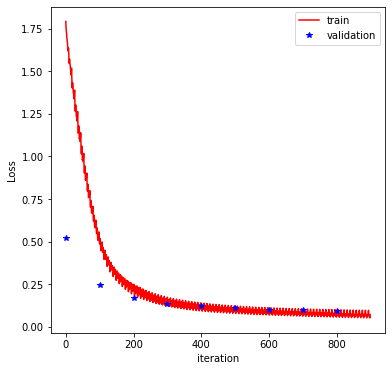

In [ ]:
# Plot training and test loss
t = np.arange(iteration-1)

plt.figure(figsize = (6,6))
plt.plot(t, np.array(train_loss), 'r-')
plt.plot(t[t % 100 == 0], np.array(validation_loss), 'b*')
plt.xlabel("iteration")
plt.ylabel("Loss")
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

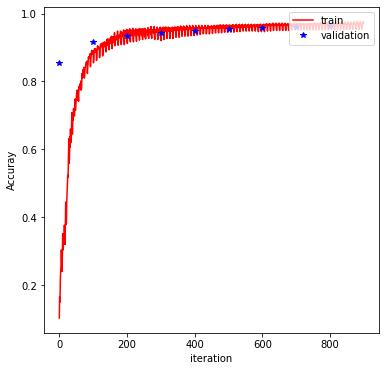

In [ ]:

# Plot Accuracies
plt.figure(figsize = (6,6))

plt.plot(t, np.array(train_acc), 'r-', t[t % 100 == 0], validation_acc, 'b*')
plt.xlabel("iteration")
plt.ylabel("Accuray")
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [ ]:
test_acc = []

#         config = tf.ConfigProto(device_count={'GPU': 0})
config = tf.ConfigProto()
#         config.gpu_options.visible_device_list= '0' #only see the gpu 1c
config.gpu_options.allow_growth = True   
with tf.Session(config=config,graph=graph) as sess:
    # Restore
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints-cnn'))
    
    for x_t, y_t in get_batches(X_test, y_test, batch_size):
        feed = {inputs_: x_t,
                labels_: y_t,
                keep_prob_: 1}
        
        batch_acc = sess.run(accuracy, feed_dict=feed)
        test_acc.append(batch_acc)
    print("Test accuracy: {:.6f}".format(np.mean(test_acc)))

INFO:tensorflow:Restoring parameters from checkpoints-cnn/har.ckpt
Test accuracy: 0.882500


In [ ]:
tf.reset_default_graph()
#         config = tf.ConfigProto(device_count={'GPU': 0})
config = tf.ConfigProto()
#         config.gpu_options.visible_device_list= '0' #only see the gpu 1
config.gpu_options.allow_growth = True   
sess = tf.InteractiveSession(config=config)

new_saver = tf.train.import_meta_graph('checkpoints-cnn/har.ckpt.meta')
new_saver.restore(sess, tf.train.latest_checkpoint('./checkpoints-cnn'))
# weights = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='.*kernel.*')
# biases = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='.*bias.*')

weights = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='.*kernel.*')
activations = tf.get_collection('DTD')
X = activations[0]

INFO:tensorflow:Restoring parameters from ./checkpoints-cnn/har.ckpt


In [ ]:
X

<tf.Tensor 'inputs:0' shape=(?, 128, 9) dtype=float32>

In [ ]:
activations

[<tf.Tensor 'inputs:0' shape=(?, 128, 9) dtype=float32>,
 <tf.Tensor 'inputs:0' shape=(?, 128, 9) dtype=float32>,
 <tf.Tensor 'CNN/layer1/conv1d/Relu:0' shape=(?, 128, 18) dtype=float32>,
 <tf.Tensor 'CNN/layer2/conv1d/Relu:0' shape=(?, 128, 36) dtype=float32>,
 <tf.Tensor 'CNN/layer3/conv1d/Relu:0' shape=(?, 128, 72) dtype=float32>,
 <tf.Tensor 'CNN/layer4/conv1d/Relu:0' shape=(?, 128, 144) dtype=float32>,
 <tf.Tensor 'CNN/layer5/Reshape:0' shape=(?, 18432) dtype=float32>,
 <tf.Tensor 'CNN/layer5/Softmax:0' shape=(?, 6) dtype=float32>]

In [ ]:
weights

[<tf.Variable 'CNN/layer1/conv1d/kernel:0' shape=(2, 9, 18) dtype=float32_ref>,
 <tf.Variable 'CNN/layer2/conv1d/kernel:0' shape=(2, 18, 36) dtype=float32_ref>,
 <tf.Variable 'CNN/layer3/conv1d/kernel:0' shape=(2, 36, 72) dtype=float32_ref>,
 <tf.Variable 'CNN/layer4/conv1d/kernel:0' shape=(2, 72, 144) dtype=float32_ref>,
 <tf.Variable 'CNN/layer5/dense/kernel:0' shape=(18432, 6) dtype=float32_ref>]

In [ ]:
from tensorflow.python.ops import nn_ops, gen_nn_ops
from tensorflow.python.layers import pooling
class Taylor:

    def __init__(self, activations, weights, conv_ksize, pool_ksize, conv_strides, pool_strides, name):

        self.last_ind = len(activations)
        for op in activations[::-1]:
            self.last_ind -= 1
            if any([word in op.name for word in ['conv', 'pooling', 'dense']]):
                break

        self.activations = activations
        self.weights = weights
        self.conv_ksize = conv_ksize
        self.pool_ksize = pool_ksize
        self.conv_strides = conv_strides
        self.pool_strides = pool_strides
        self.name = name
    
    def __call__(self, logit):
        with tf.name_scope(self.name):
            Rs = []
            j = 0

            for i in range(len(self.activations) - 2):

                if i is self.last_ind:

                    if 'conv' in self.activations[i].name.lower():
                        Rs.append(self.backprop_conv_input(self.activations[i + 1], self.weights[j], Rs[-1], self.conv_strides))
                    else:
                        Rs.append(self.backprop_dense_input(self.activations[i + 1], self.weights[j], Rs[-1]))

                    continue

                if i is 0:
                    Rs.append(self.activations[i][:,logit,None])
                    Rs.append(self.backprop_dense(self.activations[i + 1], self.weights[j][:,logit,None], Rs[-1]))
                    j += 1

                    continue

                elif 'dense' in self.activations[i].name.lower():
                    Rs.append(self.backprop_dense(self.activations[i + 1], self.weights[j], Rs[-1]))
                    j += 1
                elif 'reshape' in self.activations[i].name.lower():
                    shape = self.activations[i + 1].get_shape().as_list()
                    shape[0] = -1
                    Rs.append(tf.reshape(Rs[-1], shape))
                elif 'conv' in self.activations[i].name.lower():
                    Rs.append(self.backprop_conv(self.activations[i + 1], self.weights[j], Rs[-1], self.conv_strides))
                    j += 1
                else:
                    raise Error('Unknown operation.')

            return Rs[-1]

    def backprop_conv(self, activation, kernel, relevance, strides, padding='SAME'):
        W_p = tf.maximum(0., kernel)
        z = nn_ops.conv1d(activation, W_p, strides, padding) + 1e-10
        s = relevance / z
        print(tf.shape(s))
        c = nn_ops.conv1d_transpose(s, W_p, tf.shape(activation), strides, padding)
        return activation * c

    def backprop_dense(self, activation, kernel, relevance):
        W_p = tf.maximum(0., kernel)
        z = tf.matmul(activation, W_p) + 1e-10
        s = relevance / z
        c = tf.matmul(s, tf.transpose(W_p))
        return activation * c

    def backprop_conv_input(self, X, kernel, relevance, strides, padding='SAME', lowest=0., highest=1.):
        W_p = tf.maximum(0., kernel)
        W_n = tf.minimum(0., kernel)

        L = tf.ones_like(X, tf.float32) * lowest
        H = tf.ones_like(X, tf.float32) * highest

        z_o = nn_ops.conv1d(X, kernel, strides, padding)
        z_p = nn_ops.conv1d(L, W_p, strides, padding)
        z_n = nn_ops.conv1d(H, W_n, strides, padding)

        z = z_o - z_p - z_n + 1e-10
        s = relevance / z

        c_o = nn_ops.conv1d_transpose(s, kernel, tf.shape(X), strides, padding)
        c_p = nn_ops.conv1d_transpose(s, W_p, tf.shape(X), strides, padding)
        c_n = nn_ops.conv1d_transpose(s, W_n, tf.shape(X), strides, padding)

        return X * c_o - L * c_p - H * c_n

    def backprop_dense_input(self, X, kernel, relevance, lowest=0., highest=1.):
        W_p = tf.maximum(0., kernel)
        W_n = tf.minimum(0., kernel)

        L = tf.ones_like(X, tf.float32) * lowest
        H = tf.ones_like(X, tf.float32) * highest

        z_o = tf.matmul(X, kernel)
        z_p = tf.matmul(L, W_p)
        z_n = tf.matmul(H, W_n)

        z = z_o - z_p - z_n + 1e-10
        s = relevance / z

        c_o = tf.matmul(s, tf.transpose(kernel))
        c_p = tf.matmul(s, tf.transpose(W_p))
        c_n = tf.matmul(s, tf.transpose(W_n))

        return X * c_o - L * c_p - H * c_n

In [ ]:
conv_ksize = 2
pool_ksize = 2
conv_strides = 1
pool_strides = 2

weights.reverse()
activations.reverse()

In [ ]:
taylor = Taylor(activations, weights, conv_ksize, pool_ksize, conv_strides, pool_strides, 'Taylor')

In [ ]:
Rs = []
for i in range(6):
    Rs.append(taylor(i))

Tensor("Taylor/Shape:0", shape=(3,), dtype=int32)
Tensor("Taylor/Shape_2:0", shape=(3,), dtype=int32)
Tensor("Taylor/Shape_4:0", shape=(3,), dtype=int32)
Tensor("Taylor_1/Shape:0", shape=(3,), dtype=int32)
Tensor("Taylor_1/Shape_2:0", shape=(3,), dtype=int32)
Tensor("Taylor_1/Shape_4:0", shape=(3,), dtype=int32)
Tensor("Taylor_2/Shape:0", shape=(3,), dtype=int32)
Tensor("Taylor_2/Shape_2:0", shape=(3,), dtype=int32)
Tensor("Taylor_2/Shape_4:0", shape=(3,), dtype=int32)
Tensor("Taylor_3/Shape:0", shape=(3,), dtype=int32)
Tensor("Taylor_3/Shape_2:0", shape=(3,), dtype=int32)
Tensor("Taylor_3/Shape_4:0", shape=(3,), dtype=int32)
Tensor("Taylor_4/Shape:0", shape=(3,), dtype=int32)
Tensor("Taylor_4/Shape_2:0", shape=(3,), dtype=int32)
Tensor("Taylor_4/Shape_4:0", shape=(3,), dtype=int32)
Tensor("Taylor_5/Shape:0", shape=(3,), dtype=int32)
Tensor("Taylor_5/Shape_2:0", shape=(3,), dtype=int32)
Tensor("Taylor_5/Shape_4:0", shape=(3,), dtype=int32)


In [ ]:
sample_imgs = []
for i in range(6):
    sample_imgs.append(X_tr[np.argmax(y_tr, axis=1) == i][10])

In [ ]:
imgs = []
for i in range(6):
    imgs.append(sess.run(Rs[i], feed_dict={X: sample_imgs[i][None,:]}))

In [ ]:
imgs = np.squeeze(imgs)
sample_imgs = np.squeeze(sample_imgs)

1 WALKING
2 WALKING_UPSTAIRS
3 WALKING_DOWNSTAIRS
4 SITTING
5 STANDING
6 LAYING

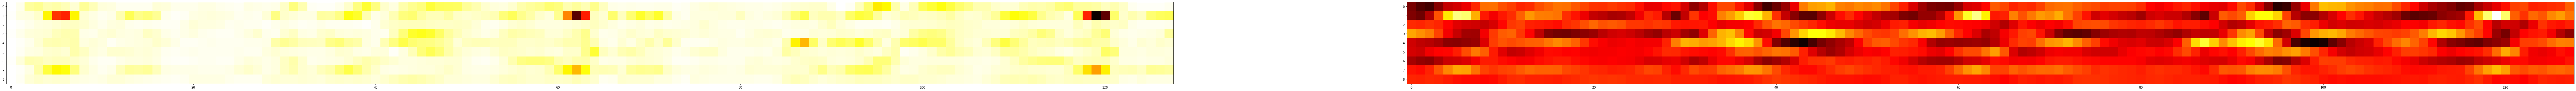

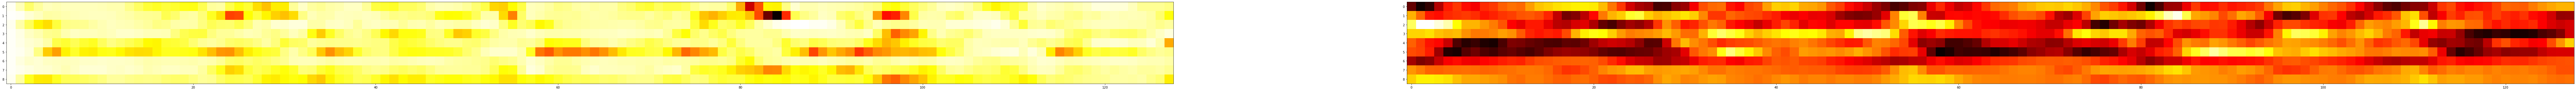

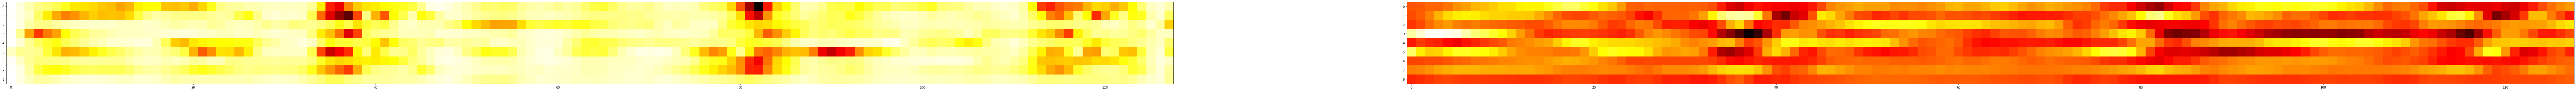

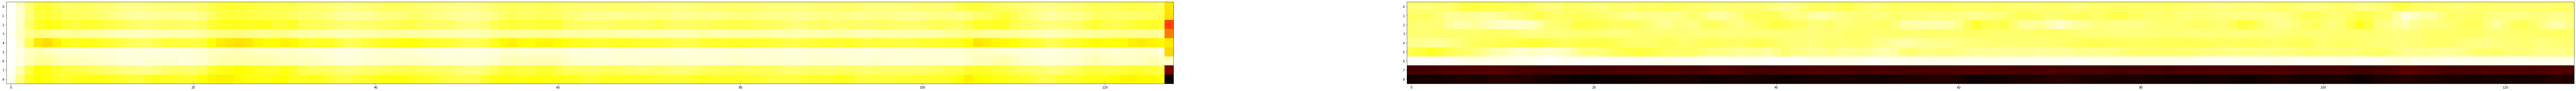

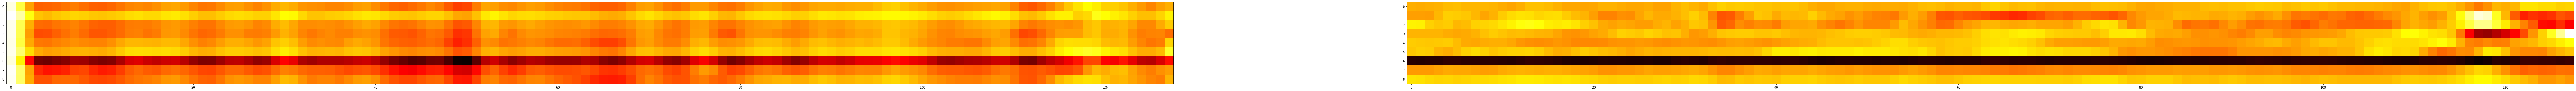

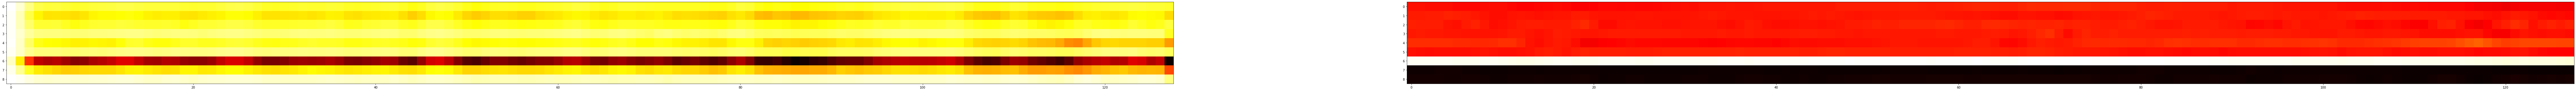

In [ ]:
for i in range(6):
    plt.figure(figsize=(150,150))
    plt.subplot(1, 2, 1)
    plt.imshow(np.transpose(imgs[i]), cmap='hot_r')
    plt.subplot(1, 2, 2)
    plt.imshow(np.transpose(sample_imgs[i]), cmap='hot_r')

In [ ]:
# Activities are the class labels
# It is a 6 class classification
ACTIVITIES = {
    0: 'WALKING',
    1: 'WALKING_UPSTAIRS',
    2: 'WALKING_DOWNSTAIRS',
    3: 'SITTING',
    4: 'STANDING',
    5: 'LAYING',
}
import matplotlib.pyplot as plt
import seaborn as sns

# function to print the confusion matrix

def confusion_matrix(Y_true, Y_pred):
    
    Y_true = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_true, axis=1)])
    Y_pred = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_pred, axis=1)])

    return pd.crosstab(Y_true, Y_pred, rownames=['True'], colnames=['Pred'])

    
   # result = confusion_matrix(Y_true, Y_pred)

    #plt.figure(figsize=(10, 8))
   # sns.heatmap(result, 
    #            xticklabels= list(ACTIVITIES.values()), 
     #           yticklabels=list(ACTIVITIES.values()), 
      #          annot=True, fmt="d");
   # plt.title("Confusion matrix")
   # plt.ylabel('True label')
   # plt.xlabel('Predicted label')
    plt.show()

In [ ]:
sess.run([prediction],feed_dict={X: X_train })

NameError: ignored

In [ ]:

# Confusion Matrix
confusion_matrix(y_test1, sess.run)

TypeError: ignored

In [ ]:
X_test

array([[[ 9.81616894e-02, -2.56848980e-01,  1.10518327e+00, ...,
          5.64903523e-01, -6.71884469e-01, -1.81852812e-01],
        [ 1.06662564e-01, -3.50594093e-01,  1.58845704e+00, ...,
          5.67013285e-01, -7.00368573e-01, -9.83872066e-03],
        [ 9.81760832e-02, -4.69241851e-01,  2.24328169e+00, ...,
          5.61312554e-01, -7.33840079e-01,  2.20782694e-01],
        ...,
        [ 1.28749674e-03,  1.09621291e-01,  7.52712314e-02, ...,
          4.29994267e-01, -6.39938843e-01,  2.16018002e-01],
        [ 4.75192841e-03,  9.83780464e-02,  7.92984231e-02, ...,
          4.31761398e-01, -6.40480300e-01,  2.17103259e-01],
        [ 2.01779582e-02,  8.17247479e-02,  9.21692659e-02, ...,
          4.40542598e-01, -6.43815638e-01,  2.20574196e-01]],

       [[ 8.49713663e-02,  3.73954559e-02, -2.71843553e-01, ...,
          4.60277297e-01, -6.60037530e-01,  1.50094069e-01],
        [ 6.13275521e-02,  1.26616144e-01, -2.76062448e-01, ...,
          4.49649420e-01, -6.34951016e

In [ ]:
y_test

array([[0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       ...,
       [0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.]])

In [ ]:
y_test1=y_test.astype('uint8')

In [ ]:
y_test1

array([[0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1, 0],
       ...,
       [0, 1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0]], dtype=uint8)

In [ ]:
X_test

array([[[ 9.81616894e-02, -2.56848980e-01,  1.10518327e+00, ...,
          5.64903523e-01, -6.71884469e-01, -1.81852812e-01],
        [ 1.06662564e-01, -3.50594093e-01,  1.58845704e+00, ...,
          5.67013285e-01, -7.00368573e-01, -9.83872066e-03],
        [ 9.81760832e-02, -4.69241851e-01,  2.24328169e+00, ...,
          5.61312554e-01, -7.33840079e-01,  2.20782694e-01],
        ...,
        [ 1.28749674e-03,  1.09621291e-01,  7.52712314e-02, ...,
          4.29994267e-01, -6.39938843e-01,  2.16018002e-01],
        [ 4.75192841e-03,  9.83780464e-02,  7.92984231e-02, ...,
          4.31761398e-01, -6.40480300e-01,  2.17103259e-01],
        [ 2.01779582e-02,  8.17247479e-02,  9.21692659e-02, ...,
          4.40542598e-01, -6.43815638e-01,  2.20574196e-01]],

       [[ 8.49713663e-02,  3.73954559e-02, -2.71843553e-01, ...,
          4.60277297e-01, -6.60037530e-01,  1.50094069e-01],
        [ 6.13275521e-02,  1.26616144e-01, -2.76062448e-01, ...,
          4.49649420e-01, -6.34951016e